# Clustering teams based on their playstyle and league

In [241]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, davies_bouldin_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [242]:
# Step 1: Load the processed data
file_path = '../data/final_team_cluster_data2.csv'
final_team_cluster_data = pd.read_csv(file_path)

In [243]:
# Add league information from the matches dataset
matches_file_path = '../data/ginf.csv'
matches_data = pd.read_csv(matches_file_path)
team_league_map = pd.concat([matches_data[['ht', 'league']], matches_data[['at', 'league']].rename(columns={'at': 'ht'})])
team_league_map = team_league_map.drop_duplicates().set_index('ht')['league'].to_dict()
final_team_cluster_data['league'] = final_team_cluster_data['event_team'].map(team_league_map)

In [244]:
# Verify league column
print("\nNumber of Teams from Each League:")
print(final_team_cluster_data['league'].value_counts())


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     26
D1     26
Name: count, dtype: int64


In [245]:
# Step 2: Prepare data for clustering
team_names = final_team_cluster_data['event_team']
league_labels = final_team_cluster_data['league']  # Actual league labels
clustering_features = final_team_cluster_data.drop(columns=['event_team', 'league'])

In [246]:
# Step 3: Apply RandomOverSampler
print("\nBefore Oversampling:")
print(final_team_cluster_data['league'].value_counts())


Before Oversampling:
league
F1     30
I1     30
SP1    30
E0     26
D1     26
Name: count, dtype: int64


In [247]:
# Use oversampling to balance the dataset based on league labels
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(clustering_features, league_labels)

In [248]:
print("\nAfter Oversampling:")
print(pd.Series(y_resampled).value_counts())


After Oversampling:
league
F1     30
I1     30
SP1    30
E0     30
D1     30
Name: count, dtype: int64


In [249]:
# Create a new DataFrame with oversampled data
oversampled_data = pd.DataFrame(X_resampled, columns=clustering_features.columns)
oversampled_data['league'] = y_resampled

C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2535875407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  oversampled_data['league'] = y_resampled


In [250]:
# Add original indices to the oversampled dataset
oversampled_data['original_index'] = oversampled_data.index

C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2709401424.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  oversampled_data['original_index'] = oversampled_data.index


In [251]:
# Step 4: Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(oversampled_data.drop(columns=['league', 'original_index']))
oversampled_data_scaled = pd.DataFrame(scaled_features, columns=clustering_features.columns)
oversampled_data_scaled['league'] = oversampled_data['league']
oversampled_data_scaled['original_index'] = oversampled_data['original_index']

In [252]:
# Step 5: Apply BIRCH clustering
best_model_birch = None
best_metrics_birch = {'score': -np.inf}
threshold_values = np.linspace(0.1, 0.9, 9)
n_clusters = 5  # Fixed to 5 for league clustering

weights = {
    'silhouette': 0.4,
    'davies_bouldin': -0.3,
    'ari': 0.15,
    'homogeneity': 0.1,
    'completeness': 0.05
}

In [253]:
for threshold in tqdm(threshold_values, desc="Tuning BIRCH"):
    birch_model = Birch(n_clusters=n_clusters, threshold=threshold)
    birch_model.fit(oversampled_data_scaled.drop(columns=['league', 'original_index']))
    labels = birch_model.labels_

    if len(set(labels)) > 1:
        silhouette = silhouette_score(oversampled_data_scaled.drop(columns=['league', 'original_index']), labels)
        dbi = davies_bouldin_score(oversampled_data_scaled.drop(columns=['league', 'original_index']), labels)
        ari = adjusted_rand_score(y_resampled, labels)
        homogeneity = homogeneity_score(y_resampled, labels)
        completeness = completeness_score(y_resampled, labels)

        weighted_score = (
            weights['silhouette'] * silhouette +
            weights['davies_bouldin'] * (1 / (1 + dbi)) +
            weights['ari'] * ari +
            weights['homogeneity'] * homogeneity +
            weights['completeness'] * completeness
        )

        if weighted_score > best_metrics_birch['score']:
            best_metrics_birch = {
                'score': weighted_score,
                'silhouette': silhouette,
                'davies_bouldin': dbi,
                'ari': ari,
                'homogeneity': homogeneity,
                'completeness': completeness,
                'threshold': threshold
            }
            best_model_birch = birch_model

Tuning BIRCH: 100%|██████████| 9/9 [00:00<00:00, 51.83it/s]


In [254]:
# Print the best hyperparameters and metrics for BIRCH
print("\nBest BIRCH Model:")
for metric, value in best_metrics_birch.items():
    if metric != 'score':
        print(f"{metric.capitalize()}: {value:.2f}")
print(f"Weighted Score: {best_metrics_birch['score']:.2f}")


Best BIRCH Model:
Silhouette: 0.18
Davies_bouldin: 1.74
Ari: 0.19
Homogeneity: 0.32
Completeness: 0.37
Threshold: 0.10
Weighted Score: 0.04


In [255]:
# Assign clusters
oversampled_data_scaled['cluster'] = best_model_birch.labels_

In [256]:
# Step 6: Predict leagues for each cluster
cluster_league_df = oversampled_data_scaled[['cluster', 'league']]

In [257]:
# Calculate league proportions within each cluster
league_distribution = cluster_league_df.groupby(['cluster', 'league']).size().unstack(fill_value=0)
league_distribution_normalized = league_distribution.div(league_distribution.sum(axis=1), axis=0)


In [258]:
# Actual league proportions
real_league_counts = oversampled_data_scaled['league'].value_counts()
real_league_proportions = real_league_counts / real_league_counts.sum()

In [259]:
# Generate all possible mappings between clusters and leagues
from itertools import permutations
possible_mappings = list(permutations(real_league_counts.index, len(league_distribution)))


In [260]:
def calculate_fit_score(mapping, league_distribution, real_league_proportions):
    score = 0
    for cluster, league in enumerate(mapping):
        cluster_league_proportion = league_distribution.iloc[cluster].get(league, 0)
        league_proportion = real_league_proportions.get(league, 0)
        score += cluster_league_proportion * league_proportion
    return score

In [261]:
# Find the best mapping
best_mapping = None
best_score = -np.inf
for mapping in possible_mappings:
    score = calculate_fit_score(mapping, league_distribution, real_league_proportions)
    if score > best_score:
        best_score = score
        best_mapping = mapping

In [262]:
# Print the best mapping
cluster_to_league_mapping = {cluster: league for cluster, league in enumerate(best_mapping)}
print("\nBest Cluster-to-League Mapping:")
for cluster, league in cluster_to_league_mapping.items():
    print(f"Cluster {cluster}: {league}")


Best Cluster-to-League Mapping:
Cluster 0: I1
Cluster 1: E0
Cluster 2: F1
Cluster 3: D1
Cluster 4: SP1


In [263]:
# Assign predicted leagues
oversampled_data_scaled['predicted_league'] = oversampled_data_scaled['cluster'].map(cluster_to_league_mapping)


In [264]:
# Step 7: Compute Accuracy
accuracy = (oversampled_data_scaled['predicted_league'] == oversampled_data_scaled['league']).mean()
print(f"\nClustering Accuracy: {accuracy:.2f}")


Clustering Accuracy: 0.43


In [265]:
# Step 6: Analyze clusters
def analyze_cluster(cluster_id, data, original_data):
    cluster_data = data[data['cluster'] == cluster_id]
    original_indices = cluster_data['original_index'].values
    valid_original_indices = [idx for idx in original_indices if idx in original_data.index]
    if not valid_original_indices:
        print(f"Cluster {cluster_id}: No valid original indices.")
        return
    representative_teams = original_data.loc[valid_original_indices, 'event_team'].head(5).tolist()

    # Select only numeric columns for cluster feature analysis
    numeric_data = cluster_data.select_dtypes(include=[np.number]).drop(columns=['cluster', 'original_index'])
    cluster_features = numeric_data.mean().sort_values(ascending=False)

    print(f"\nCluster {cluster_id} Analysis:")
    print(f"Representative Teams: {', '.join(representative_teams)}")
    print("Most Common Features:")
    print(cluster_features.head(10))

In [266]:
# Modern visualization for cluster analysis
def visualize_cluster_analysis(cluster_id, data, original_data):
    cluster_data = data[data['cluster'] == cluster_id]
    original_indices = cluster_data['original_index'].values
    valid_original_indices = [idx for idx in original_indices if idx in original_data.index]
    if not valid_original_indices:
        print(f"Cluster {cluster_id}: No valid original indices for visualization.")
        return
    representative_teams = original_data.loc[valid_original_indices, 'event_team'].head(5).tolist()

    # Select only numeric columns for visualization
    numeric_data = cluster_data.select_dtypes(include=[np.number]).drop(columns=['cluster', 'original_index'])
    cluster_features = numeric_data.mean().sort_values(ascending=False)

    print(f"\nCluster {cluster_id} Visualization:")
    print(f"Representative Teams: {', '.join(representative_teams[:5])}")

    # Heatmap of top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cluster_features.head(10).index, y=cluster_features.head(10).values, palette="viridis")
    plt.title(f'Top Features in Cluster {cluster_id}', fontsize=16)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Mean Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Cluster 2 Analysis:
Representative Teams: AC Ajaccio, AS Nancy Lorraine, Alaves, Almeria, Angers
Most Common Features:
location_17.0_x_assist_method_0    0.406014
event_type_10_x_location_17.0      0.402052
event_type_4_x_location_17.0       0.373104
event_type_6_x_assist_method_0     0.304192
event_type_10_x_assist_method_0    0.297263
event_type_3_x_assist_method_0     0.286758
event_type2_14.0                   0.278421
location_17.0_x_bodypart_2.0       0.255741
event_type_10_x_location_16.0      0.252570
event_type_10_x_assist_method_3    0.252078
dtype: float64

Cluster 2 Visualization:
Representative Teams: AC Ajaccio, AS Nancy Lorraine, Alaves, Almeria, Angers


C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2539683365.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_features.head(10).index, y=cluster_features.head(10).values, palette="viridis")


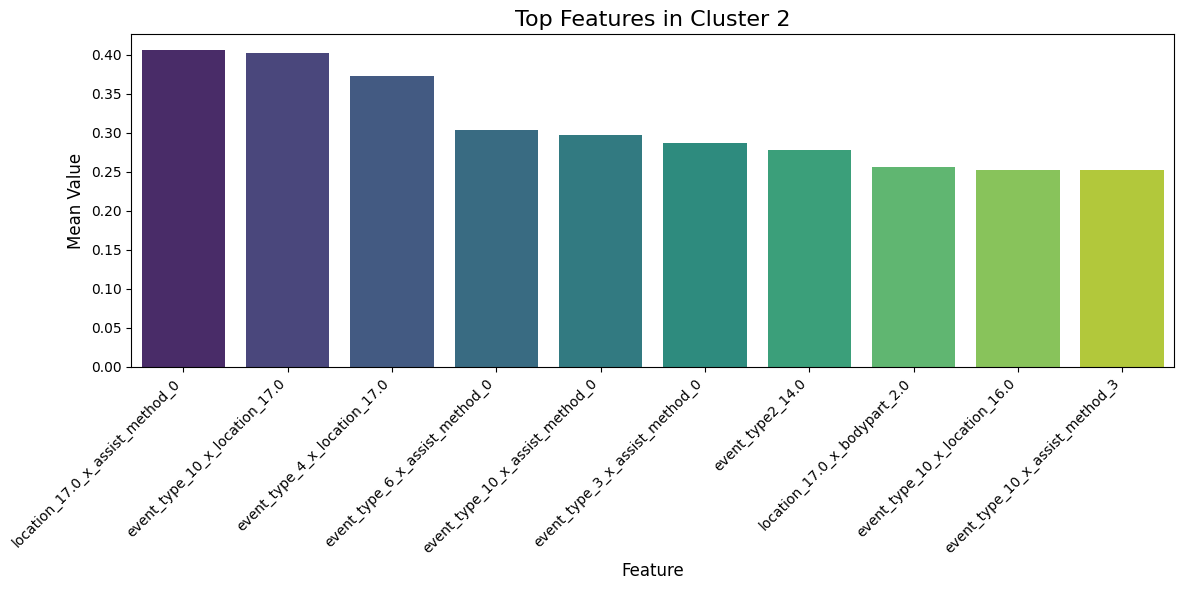


Cluster 0 Analysis:
Representative Teams: AC Milan, AS Roma, Atletico Madrid, Barcelona, Bayer Leverkusen
Most Common Features:
event_type_1_x_location_13.0          1.962156
event_type_1_x_situation_1.0          1.932784
shot_outcome_1.0_x_shot_place_5.0     1.930970
shot_outcome_1.0_x_shot_place_10.0    1.916174
event_type_1_x_assist_method_4        1.887931
event_type_1_x_location_3.0           1.876918
event_type_1_x_shot_outcome_3.0       1.865876
location_14.0_x_assist_method_4       1.859370
event_type_1_x_location_11.0          1.849373
event_type_1_x_location_9.0           1.844331
dtype: float64

Cluster 0 Visualization:
Representative Teams: AC Milan, AS Roma, Atletico Madrid, Barcelona, Bayer Leverkusen


C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2539683365.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_features.head(10).index, y=cluster_features.head(10).values, palette="viridis")


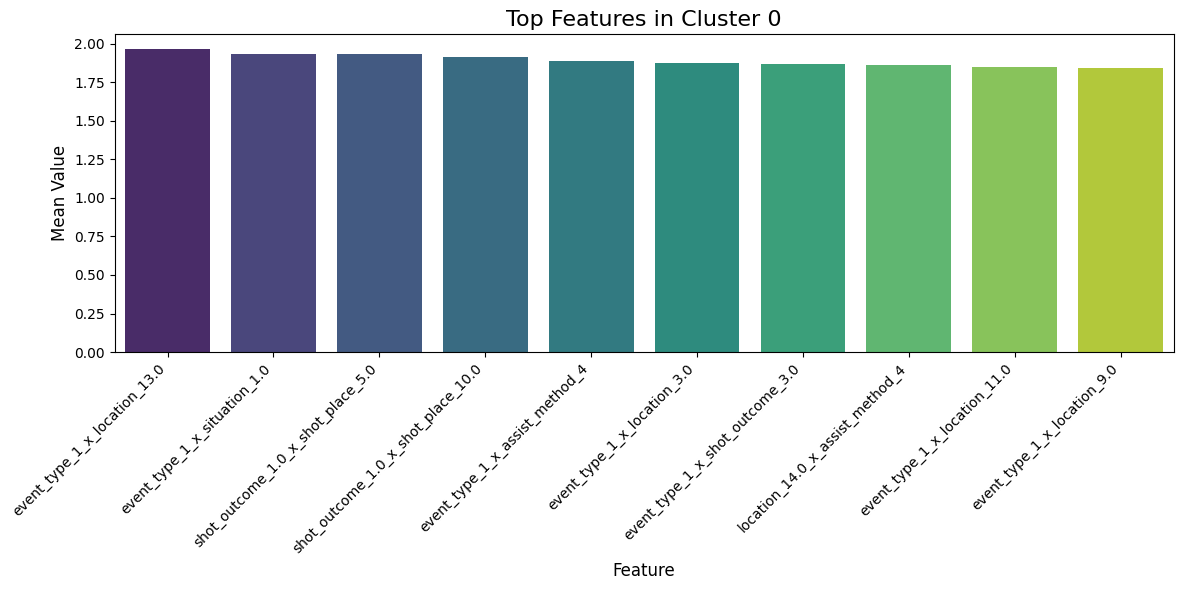


Cluster 3 Analysis:
Representative Teams: AJ Auxerre, AS Monaco, Atalanta, Athletic Bilbao, Bologna
Most Common Features:
event_type_8_x_assist_method_2    0.743569
location_5.0_x_assist_method_2    0.726635
location_5.0_x_assist_method_0    0.716289
event_type_3_x_assist_method_2    0.705538
location_4.0_x_assist_method_0    0.702577
event_type_8_x_assist_method_0    0.702461
location_1.0_x_assist_method_2    0.700694
location_4.0_x_assist_method_2    0.696242
event_type_8_x_situation_3.0      0.690089
event_type_1_x_location_5.0       0.689922
dtype: float64

Cluster 3 Visualization:
Representative Teams: AJ Auxerre, AS Monaco, Atalanta, Athletic Bilbao, Bologna


C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2539683365.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_features.head(10).index, y=cluster_features.head(10).values, palette="viridis")


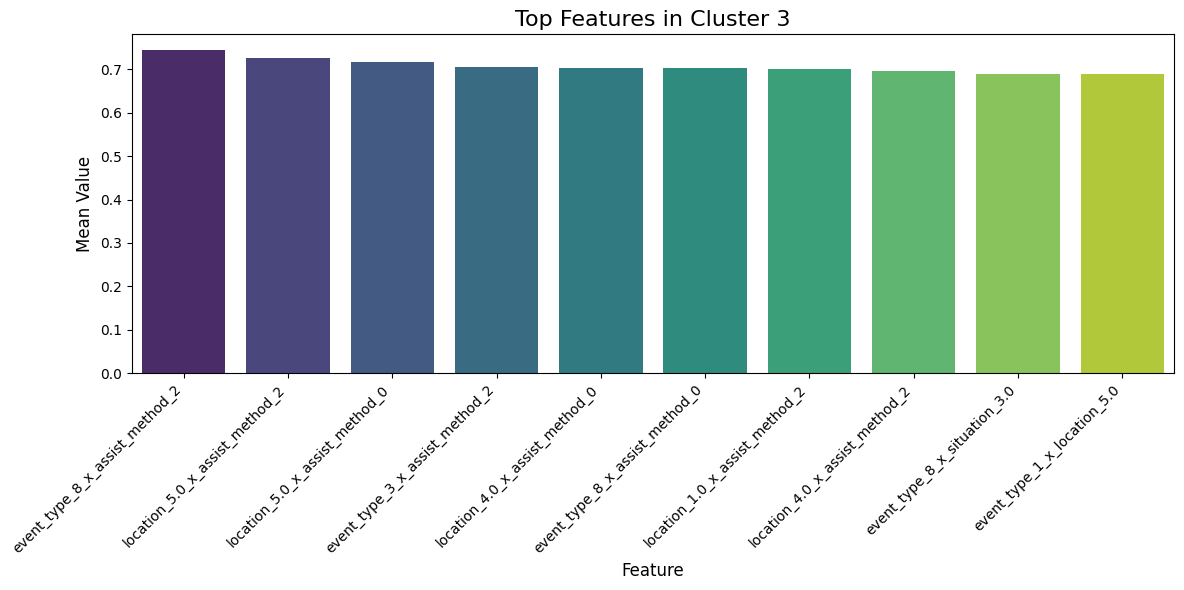


Cluster 1 Analysis:
Representative Teams: Arsenal, Aston Villa, Cardiff, Chelsea, Everton
Most Common Features:
ratio_cards_per_foul                  0.061644
event_type_5_x_assist_method_0       -0.312306
location_10.0_x_assist_method_4      -0.556557
location_14.0_x_assist_method_4      -0.603994
event_type_1_x_assist_method_4       -0.633255
location_13.0_x_assist_method_3      -0.731726
location_18.0_x_assist_method_0      -0.734455
event_type_1_x_location_13.0         -0.753204
location_13.0_x_bodypart_2.0         -0.761709
shot_outcome_4.0_x_shot_place_13.0   -0.855556
dtype: float64

Cluster 1 Visualization:
Representative Teams: Arsenal, Aston Villa, Cardiff, Chelsea, Everton


C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2539683365.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_features.head(10).index, y=cluster_features.head(10).values, palette="viridis")


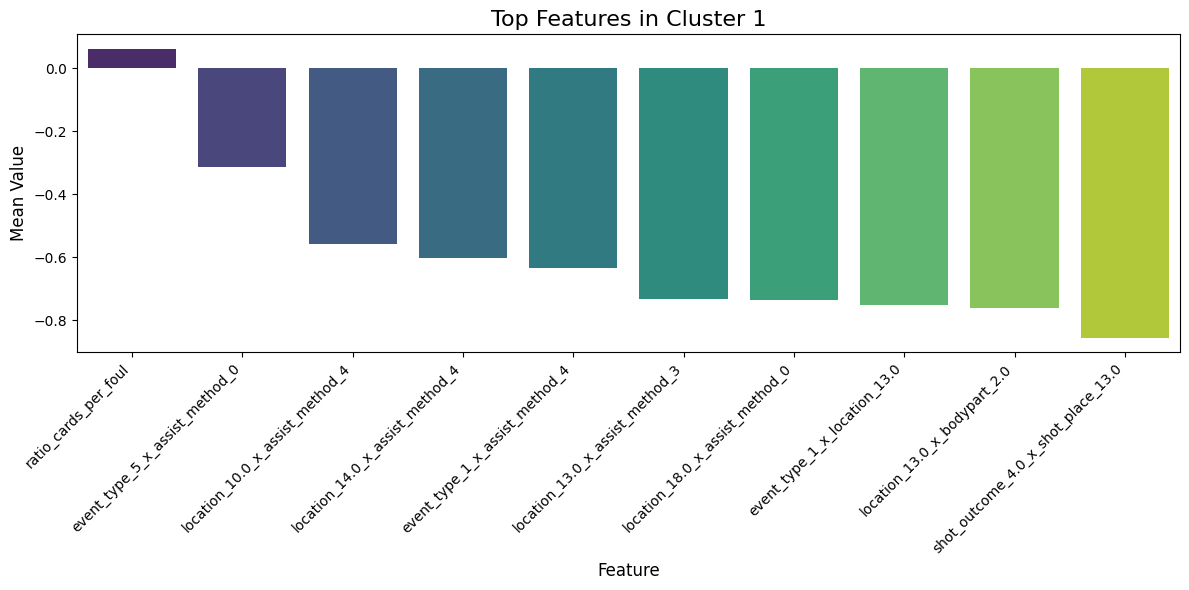


Cluster 4 Analysis:
Representative Teams: Burnley, Crystal Palace, Leicester City, Middlesbrough, Watford
Most Common Features:
location_13.0_x_assist_method_3    1.958303
location_10.0_x_assist_method_3    1.952687
location_12.0_x_assist_method_3    1.567026
location_11.0_x_assist_method_3    1.470513
event_type_1_x_assist_method_3     1.455566
location_15.0_x_assist_method_3    1.370997
location_9.0_x_assist_method_3     1.245568
event_type_3_x_assist_method_3     1.093961
event_type_4_x_assist_method_3     0.916448
location_4.0_x_assist_method_3     0.909023
dtype: float64

Cluster 4 Visualization:
Representative Teams: Burnley, Crystal Palace, Leicester City, Middlesbrough, Watford


C:\Users\stoic\AppData\Local\Temp\ipykernel_1656\2539683365.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_features.head(10).index, y=cluster_features.head(10).values, palette="viridis")


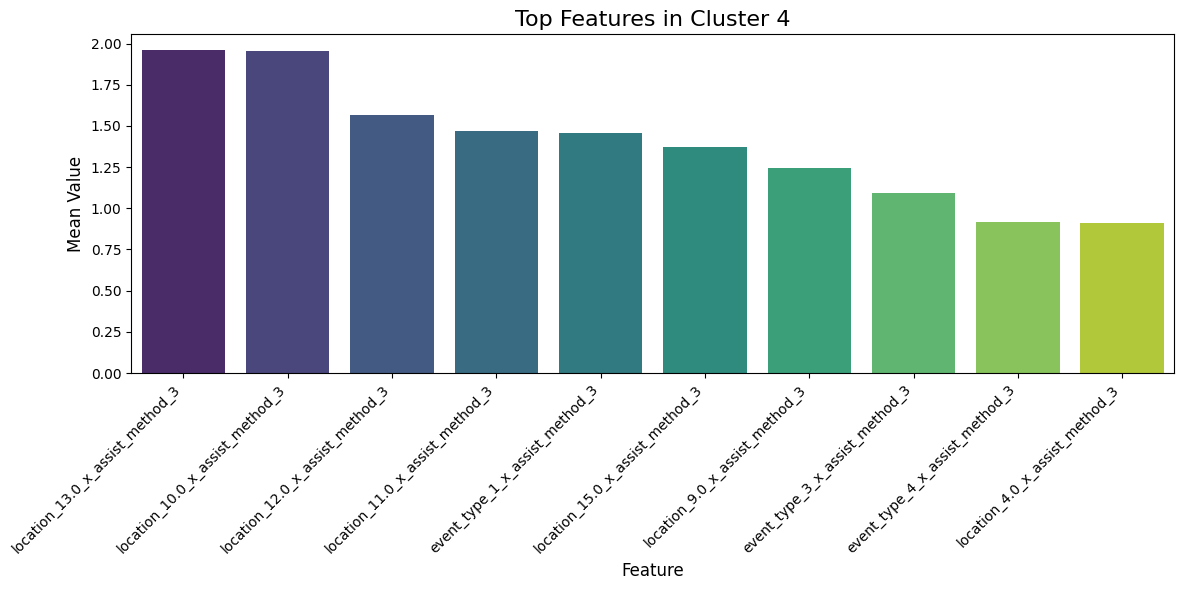

In [267]:
# Perform analysis and visualization for each cluster
unique_clusters = oversampled_data_scaled['cluster'].unique()

for cluster in unique_clusters:
    analyze_cluster(cluster, oversampled_data_scaled, final_team_cluster_data)
    visualize_cluster_analysis(cluster, oversampled_data_scaled, final_team_cluster_data)

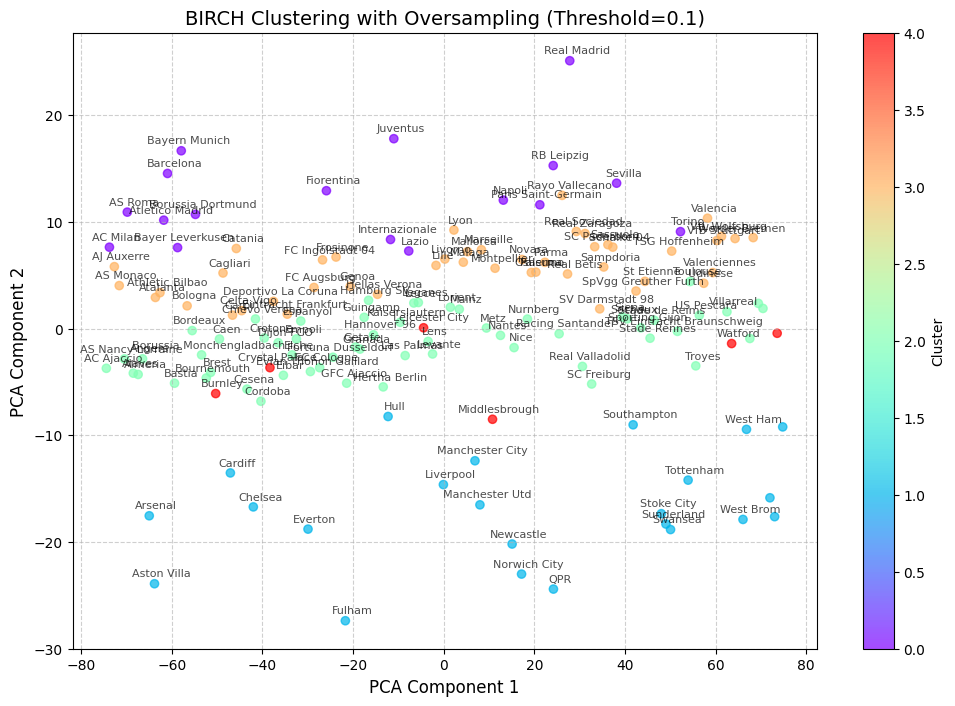


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     30
D1     30
Name: count, dtype: int64


In [268]:
# Step 8: Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(oversampled_data_scaled.drop(columns=['league', 'cluster', 'predicted_league']))
oversampled_data_scaled['pca_x'] = pca_features[:, 0]
oversampled_data_scaled['pca_y'] = pca_features[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    oversampled_data_scaled['pca_x'], 
    oversampled_data_scaled['pca_y'], 
    c=oversampled_data_scaled['cluster'], 
    cmap='rainbow', 
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'BIRCH Clustering with Oversampling (Threshold={best_metrics_birch["threshold"]})', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Annotate team names
for i, team in enumerate(team_names):
    plt.annotate(
        team,
        (oversampled_data_scaled['pca_x'][i], oversampled_data_scaled['pca_y'][i]),
        fontsize=8,
        alpha=0.7,
        textcoords="offset points",
        xytext=(5, 5),
        ha='center'
    )
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# For curiosity, print final league distribution
print("\nNumber of Teams from Each League:")
print(oversampled_data_scaled['league'].value_counts())

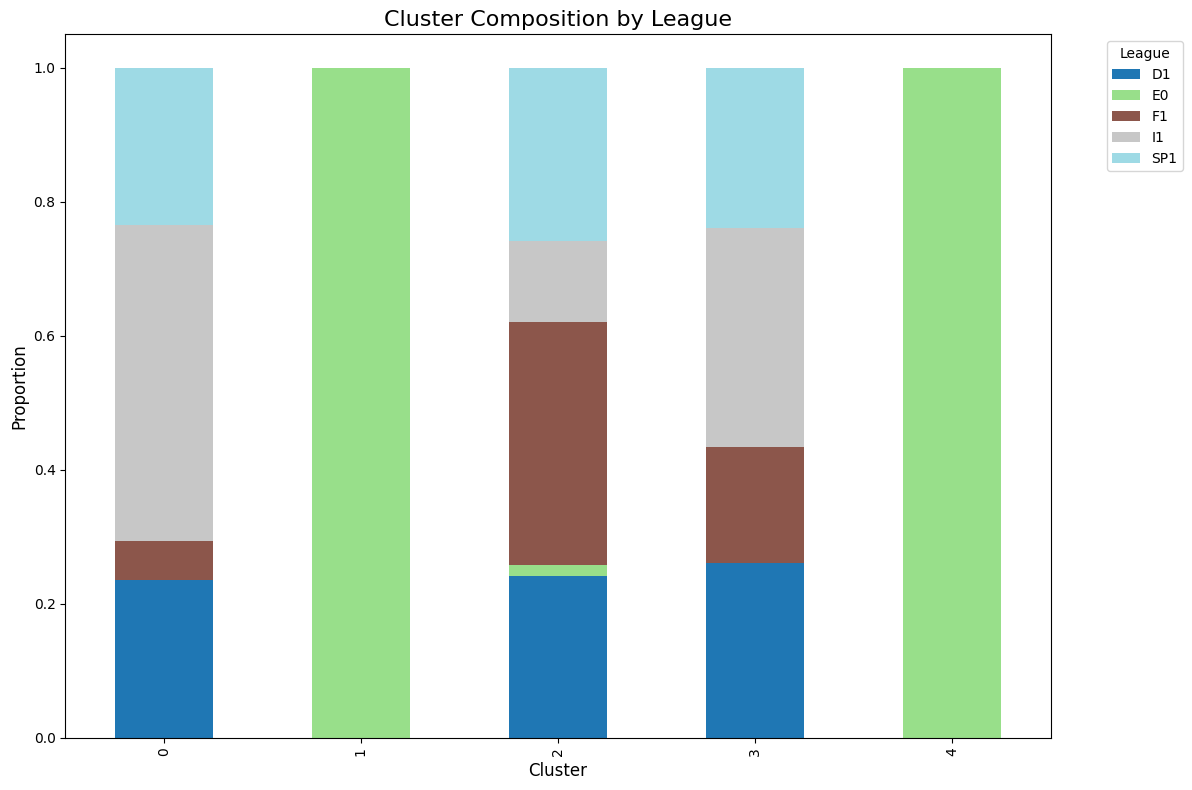

In [269]:
# Step 8: Visualize cluster composition
cluster_composition = oversampled_data_scaled.groupby('cluster')['league'].value_counts(normalize=True).unstack()

# Plot cluster composition
cluster_composition.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab20')
plt.title('Cluster Composition by League', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [270]:
# For curiosity, print final league distribution
print("\nNumber of Teams from Each League:")
print(oversampled_data_scaled['league'].value_counts())


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     30
D1     30
Name: count, dtype: int64
